In [ ]:
#Imports
# !pip install stop_words
import requests
import numpy as np
import pandas as pd
import json
import glob

from google.colab import drive

import tensorflow as tf
from tensorflow import keras

import pickle
from keras.models import load_model

# This will prompt for authorization./
drive.mount('/content/drive')
# !ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


In [31]:
cleaned_content = pd.read_csv("/content/drive/My Drive/Colab Notebooks (1)/PeerReadDataset/cleaned_data/preprocessed_final_data.csv")
cleaned_content.head(2)

,APPROPRIATENESS,Abstract,Accepted,CLARITY,Conclusion,Content,Discussion,IMPACT,Introduction,MEANINGFUL_COMPARISON,Name,ORIGINALITY,PRESENTATION_FORMAT,RECOMMENDATION,REPLICABILITY,REVIEWER_CONFIDENCE,Related_work,Result,SOUNDNESS_CORRECTNESS,SUBSTANCE,Title,Year,comments,is_meta_review,terms
0,5,We propose two novel methodologies for the aut...,1.0,4,"Our contributions are twofold. First, we devel...",Our first model is a pure neural language mode...,NaN,3.0,Poetry is an advanced form of linguistic commu...,5.0,660,4,Oral Presentation,4,NaN,3,Automatic poetry generation is an important ta...,In order to examine how effective our methodol...,3,5,Automatically Generating Rhythmic Verse with N...,2017.0,The paper presents two approaches for generati...,NaN,the paper present two approach for generating ...
1,5,We propose two novel methodologies for the aut...,1.0,3,"Our contributions are twofold. First, we devel...",Our first model is a pure neural language mode...,NaN,3.0,Poetry is an advanced form of linguistic commu...,5.0,660,4,Poster,3,NaN,4,Automatic poetry generation is an important ta...,In order to examine how effective our methodol...,3,4,Automatically Generating Rhythmic Verse with N...,2017.0,The paper describes two methodologies for the ...,NaN,the paper describes two methodology for the au...


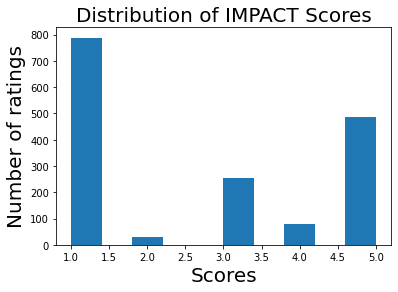

In [33]:
import matplotlib.pyplot as plt
def score_plot():
  plt.figure(figsize=(6,4))
  plt.hist(x=cleaned_content['IMPACT'])

  # Add title and axis names
  plt.title('Distribution of IMPACT Scores', fontsize=20)
  plt.ylabel('Number of ratings', fontsize=20)
  plt.xlabel('Scores', fontsize=20)

  plt.show()

score_plot()

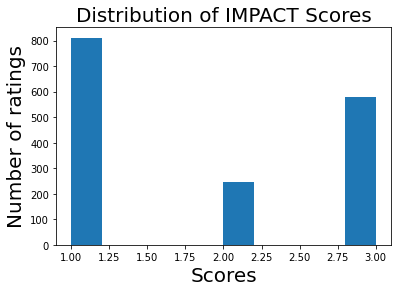

In [34]:
cleaned_content.loc[(cleaned_content.IMPACT == 2),'IMPACT']= 1
cleaned_content.loc[(cleaned_content.IMPACT == 3),'IMPACT']= 2
cleaned_content.loc[(cleaned_content.IMPACT == 4),'IMPACT']= 2
cleaned_content.loc[(cleaned_content.IMPACT == 5),'IMPACT']= 3

score_plot()

In [35]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_content['terms'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16008 unique tokens.


In [36]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(cleaned_content['terms'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1635, 500)


In [37]:
Y = pd.get_dummies(cleaned_content['IMPACT']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1635, 3)


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1308, 500) (1308, 3)
(327, 500) (327, 3)


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 1,080,703
Trainable params: 1,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
epochs = 10
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
21/21 [==============================] - 31s 1s/step - loss: 1.0669 - accuracy: 0.4320
Epoch 2/10
21/21 [==============================] - 28s 1s/step - loss: 0.9879 - accuracy: 0.4912
Epoch 3/10
21/21 [==============================] - 28s 1s/step - loss: 0.9253 - accuracy: 0.5034
Epoch 4/10
21/21 [==============================] - 28s 1s/step - loss: 0.8019 - accuracy: 0.6536
Epoch 5/10
21/21 [==============================] - 28s 1s/step - loss: 0.5888 - accuracy: 0.7731
Epoch 6/10
21/21 [==============================] - 28s 1s/step - loss: 0.3272 - accuracy: 0.8992
Epoch 7/10
21/21 [==============================] - 28s 1s/step - loss: 0.1726 - accuracy: 0.9557
Epoch 8/10
21/21 [==============================] - 28s 1s/step - loss: 0.1027 - accuracy: 0.9780
Epoch 9/10
21/21 [==============================] - 28s 1s/step - loss: 0.0585 - accuracy: 0.9837
Epoch 10/10
21/21 [==============================] - 28s 1s/step - loss: 0.0538 - accuracy: 0.9883


In [43]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

11/11 [==============================] - 1s 125ms/step - loss: 1.1786 - accuracy: 0.7401
Test set
  Loss: 1.179
  Accuracy: 0.740


In [44]:
from sklearn import metrics
from numpy import argmax
predicted = model.predict(x_test).tolist()
pred = []
val = []
for values in predicted:
    pred.append(values.index(max(values)))
for values in y_test:
    val.append(argmax(values))
print(metrics.classification_report(val, pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       165
           1       0.81      0.43      0.56        51
           2       0.65      0.76      0.70       111

    accuracy                           0.74       327
   macro avg       0.75      0.67      0.69       327
weighted avg       0.75      0.74      0.73       327



In [45]:
# Save vectorizer and model
pickle.dump(tokenizer, open("/content/drive/My Drive/Colab Notebooks (1)/PeerReadDataset/models/test_impact_vector.pickel", "wb"))
model.save('/content/drive/My Drive/Colab Notebooks (1)/PeerReadDataset/models/test_impact_model.h5')

In [50]:
new_review = ['There is no significant impact.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3']
print(pred, labels[np.argmax(pred)])

[[8.86646807e-01 6.98111660e-04 1.12655014e-01]] 1


In [47]:
new_review = ['The authors unify and improve current state-of-the-art regret bounds, improving on results from several earlier works.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3']
print(pred, labels[np.argmax(pred)])

[[0.15483055 0.05661606 0.7885535 ]] 3


In [51]:
new_review = ['This work is significant in several aspects.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3']
print(pred, labels[np.argmax(pred)])

[[0.0630117  0.20423877 0.7327496 ]] 3


In [52]:
new_review = ['I have some questions regarding some of the proofs, which impact correctness of the papers main theoretical contributions.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3']
print(pred, labels[np.argmax(pred)])

[[0.01961829 0.00659961 0.9737821 ]] 3


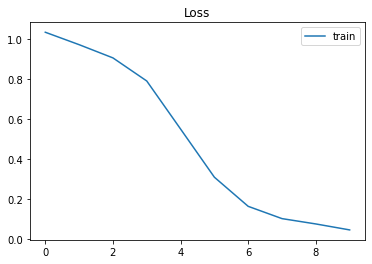

In [53]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

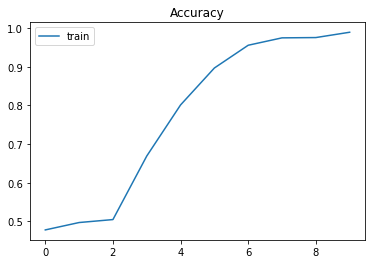

In [54]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show();